In [1]:
import numpy as np
import matplotlib as mpl
import pandas as pd
import pickle
import seaborn as sns
import shap
import xgboost as xgb

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
mpl.rcParams['figure.dpi'] = 400

c:\ProgramData\Anaconda\envs\credit_card_default\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


# Financial Analysis

# Credit Counseling Program to Minimize Losses 

In this case study, credit counseling is a planned program performed by the credit company.

 - Credit counseling sessions are personalized sessions offered by the creditor to the account owners to assist the account holders in paying their balances.
 - 70% of credit counseling sessions are successful, meaning that 70% of the time a recipient receives a credit counseling call, the recipient will pay their bill on time or will make arrangements according to the agreement of the creditor to pay their balances.
 - Each session will cost approximately New Taiwain $7,500

 What are the benefits of credit counseling?

 - Balances that defauly are considered losses. 
 - Account owners that agree to counseling and end up paying off the balance in any capacity will contribute to what is considered savings, as losses are no longer fully defaulted if at all.

 What steps would help the credit company understand the cost of a credit counseling program?

 - Understanding which accounts have a higher risk of default and should be contacted instead of lower isk accounts
 - How many calls will have to be made and how that will help establish a baseline expense / budget for the company to start a credit counseling calling program

With the logic stated above, it would make sense to approach this problem in a 'Yes'/'No' manner.
Flag accounts that are at higher risk of defaulting and should require credit counseling and flag accounts that are at lower risk of defaulting and should not require credit counseling.
 - Need to establish a predicted probability threshold that will divide accounts into low or high risk of defaulting. In doing so, the credit company will understand who to contact for credit counseling or not.
 
       - Explore expected savings from preventing defaults as well as potential costs of credit counseling program at varying thresholds and present to credit company
       - Use most recent month of bills for potential savings if defaults are prevented

In [16]:
with open('../Data/rf_model.pkl', 'rb') as file:
    rf = pickle.load(file)

In [6]:
with open('../Data/dataset_dict.pickle', 'rb') as file:
    dataset_dict = pickle.load(file)

In [28]:
X_train = dataset_dict['X_train']
X_test = dataset_dict['X_test']
y_train = dataset_dict['y_train']
y_test = dataset_dict['y_test']

In [22]:
y_pred = rf.predict(X_test)

In [21]:
y_pred_proba = rf.predict_proba(X_test)[:, 1]
y_pred_proba

array([0.49730166, 0.50061215, 0.07489059, ..., 0.10004027, 0.38162095,
       0.68428737])

In [32]:
thresholds = np.linspace(0, 1, 101)

In [33]:
thresholds

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [10]:
features = ['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

#  BILL_AMT1 will be employed for analysis on potential savings (balances that are not defaulted via counseling considered savings)

In [27]:
X_test[:, 5]

array([  776, 49612, 73508, ...,  2531,     0, 57214], dtype=int64)

In [12]:
counseling_cost = 7500
counseling_effectiveness = 0.70

# Net Savings

In [49]:
# Creating empty arrays for values that will change with varying thresholds
n_pos_pred = np.empty_like(thresholds)
total_cost = np.empty_like(thresholds)
n_true_pos = np.empty_like(thresholds)
total_savings = np.empty_like(thresholds)

In [51]:
counter = 0 
for threshold in thresholds:
    pos_pred = y_pred_proba > threshold
    n_pos_pred[counter] = sum(pos_pred)
    total_cost[counter] = counseling_cost * n_pos_pred[counter]
    true_pos = pos_pred & y_test.astype(bool)  # Of predictions, which are true positives
    n_true_pos[counter] = sum(true_pos)
    total_balances = np.sum(X_test[:, 5][true_pos.astype(int)])
    potential_savings = counseling_effectiveness * total_balances
    total_savings[counter] = potential_savings
    counter += 1


In [53]:
# Net savings can be calculated by subtracting total costs from total savings for each threshold
net_savings = total_savings - total_cost

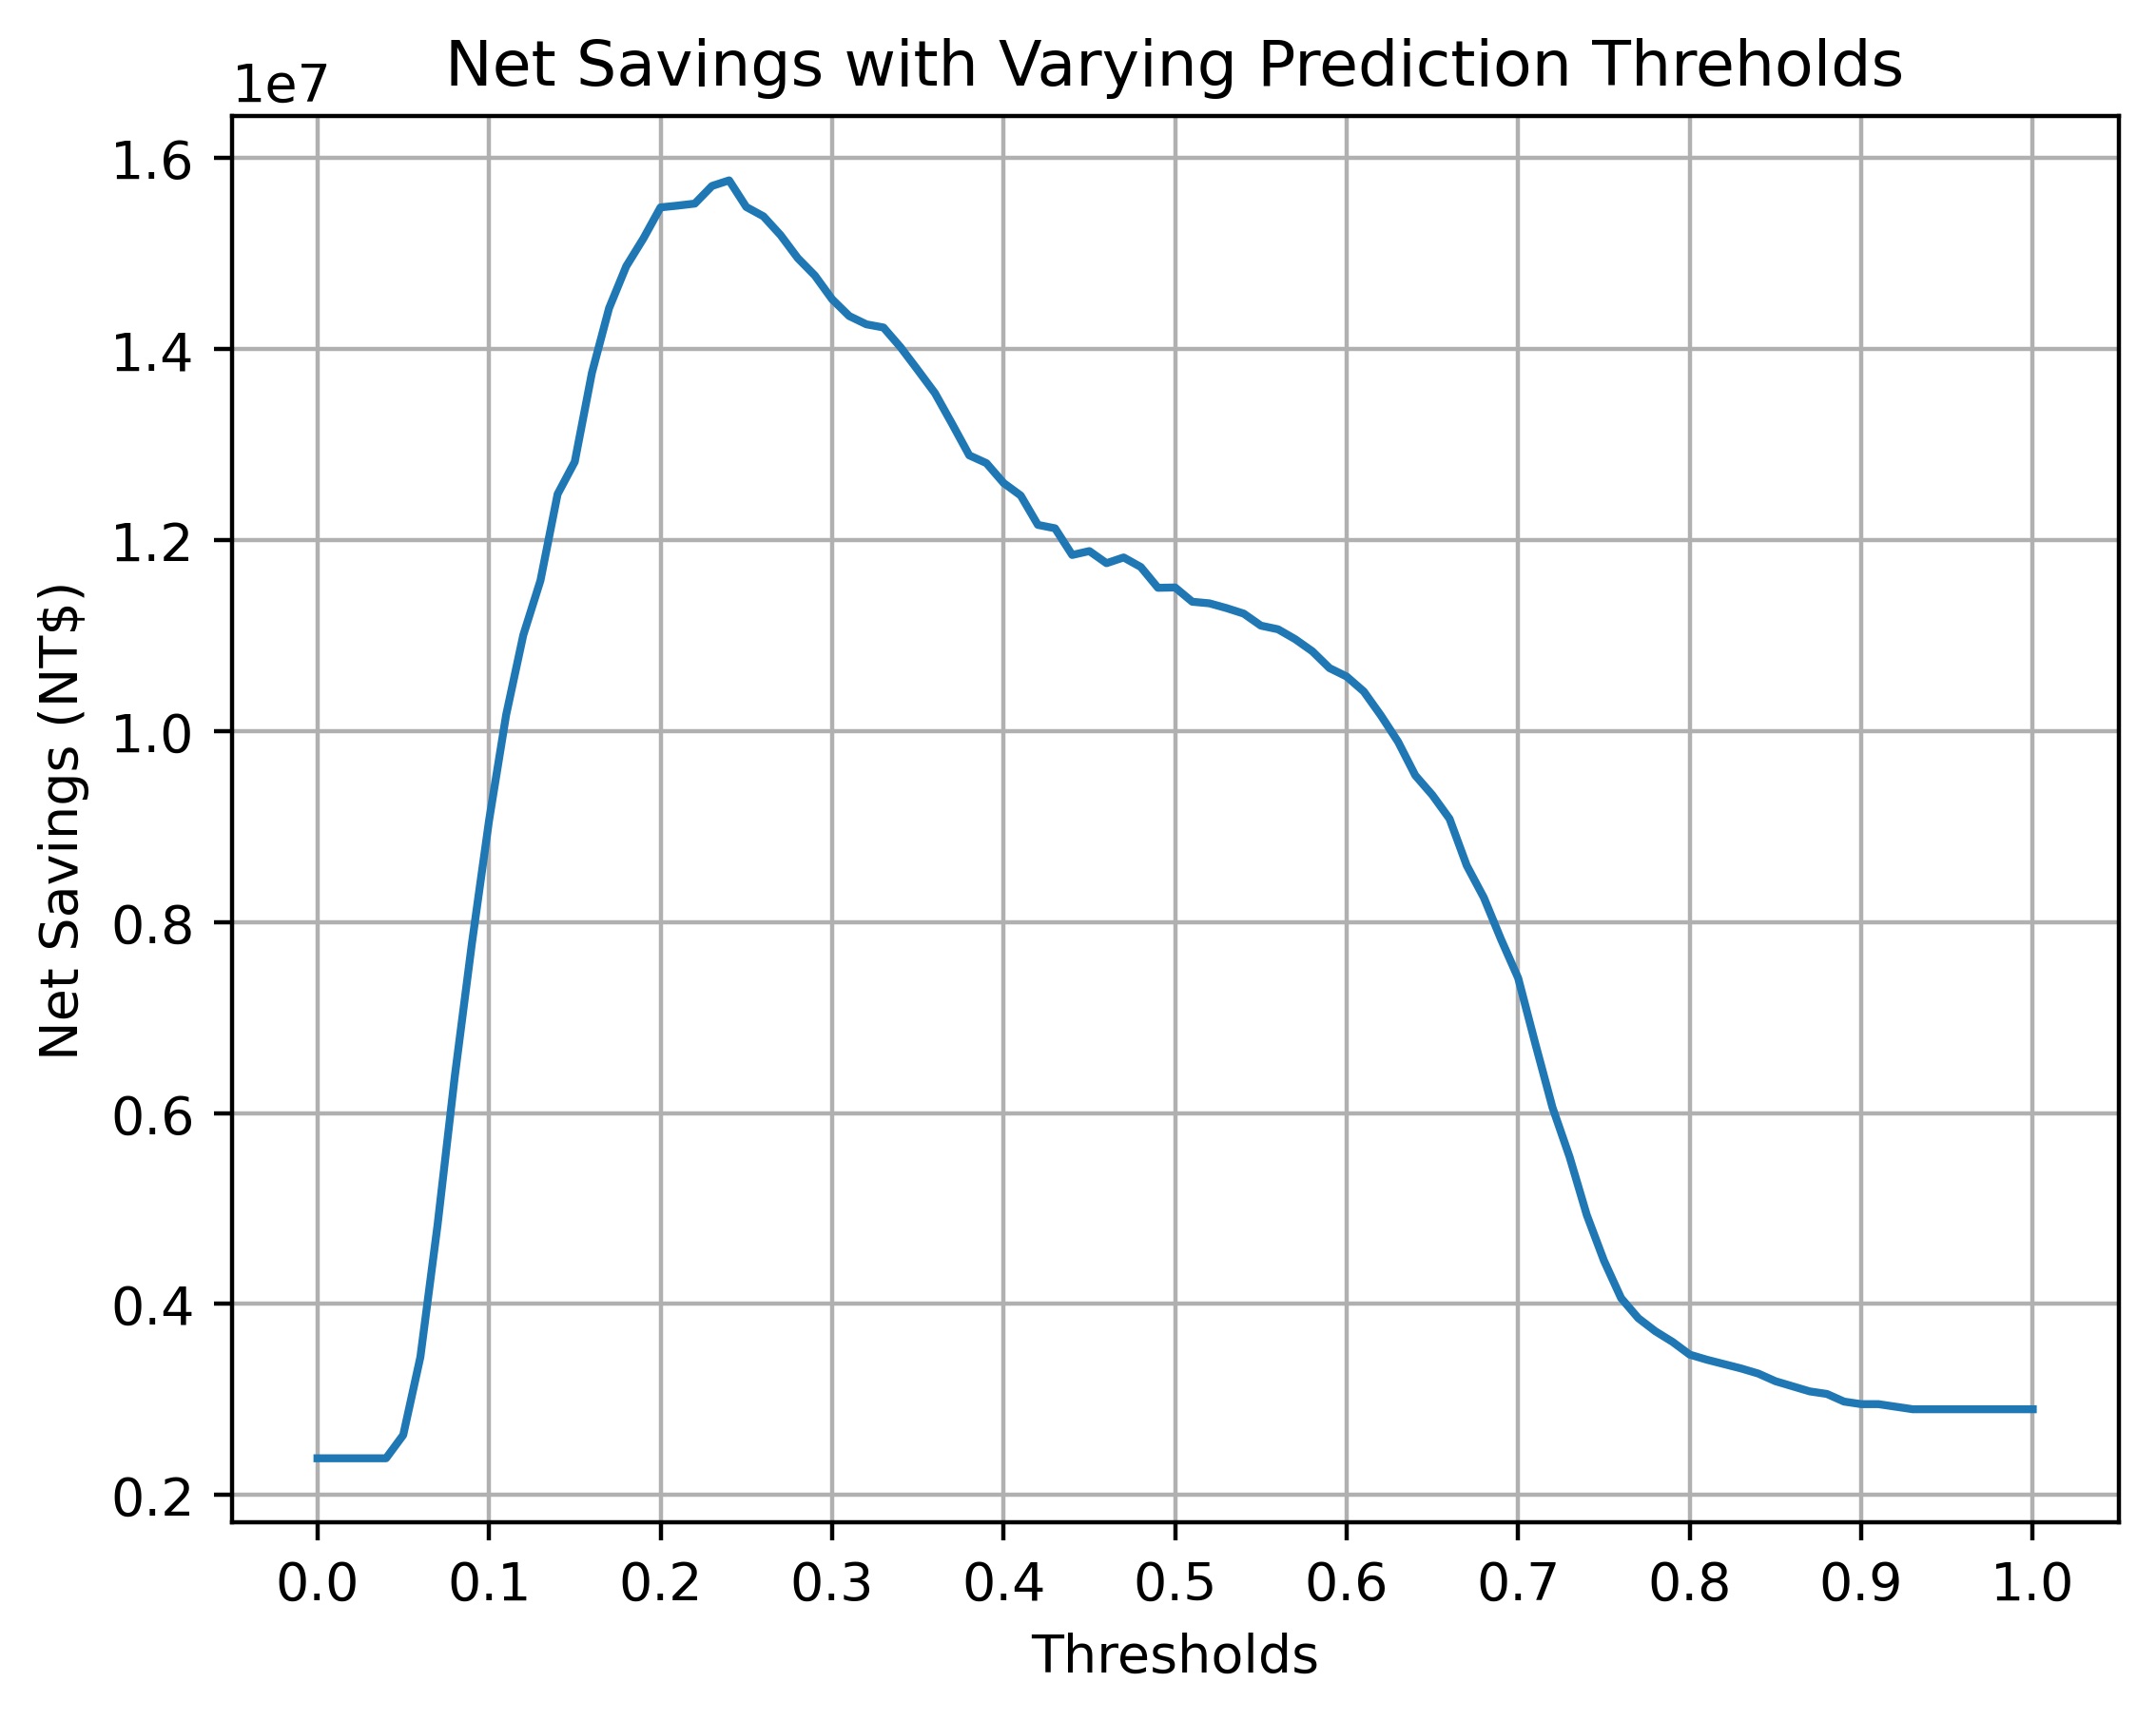

In [56]:
mpl.rcParams['figure.dpi'] = 400
plt.plot(thresholds, net_savings)
plt.xlabel('Thresholds')
plt.ylabel('Net Savings (NT$)')
plt.title('Net Savings with Varying Prediction Threholds')
plt.xticks(np.linspace(0, 1, 11))
plt.grid(True)

In [77]:
max_savings_index = np.argmax(net_savings)
max_savings_threshold = thresholds[max_savings_index]
max_savings = net_savings[max_savings_index]
print('Max net savings occurred on index {}, which shows a max net savings value of NT ${}'.format(max_savings_threshold, format(int(max_savings), ',d')))

Max net savings occurred on index 0.24, which shows a max net savings value of NT $15,767,877


# Savings vs Costs

In [96]:
total_cost_all_defaults = np.sum(X_test[:, 5] * y_test)
print('Cost of defaults ($NT): {}'.format(format(int(total_cost_all_defaults), ',d')))
percent_loss_prevention = net_savings[max_savings_index] / total_cost_all_defaults
print('Percent of defaults saved: {}%'.format(round(percent_loss_prevention * 100), 1))
print('Net savings per account ($NT): {}'.format(format(int(net_savings[max_savings_index] / len(y_test)), ',d')))

Cost of defaults ($NT): 55,198,017
Percent of defaults saved: 29%
Net savings per account ($NT): 2,956


Text(0.5, 1.0, 'Upfront Cost of Counseling vs Net Savings')

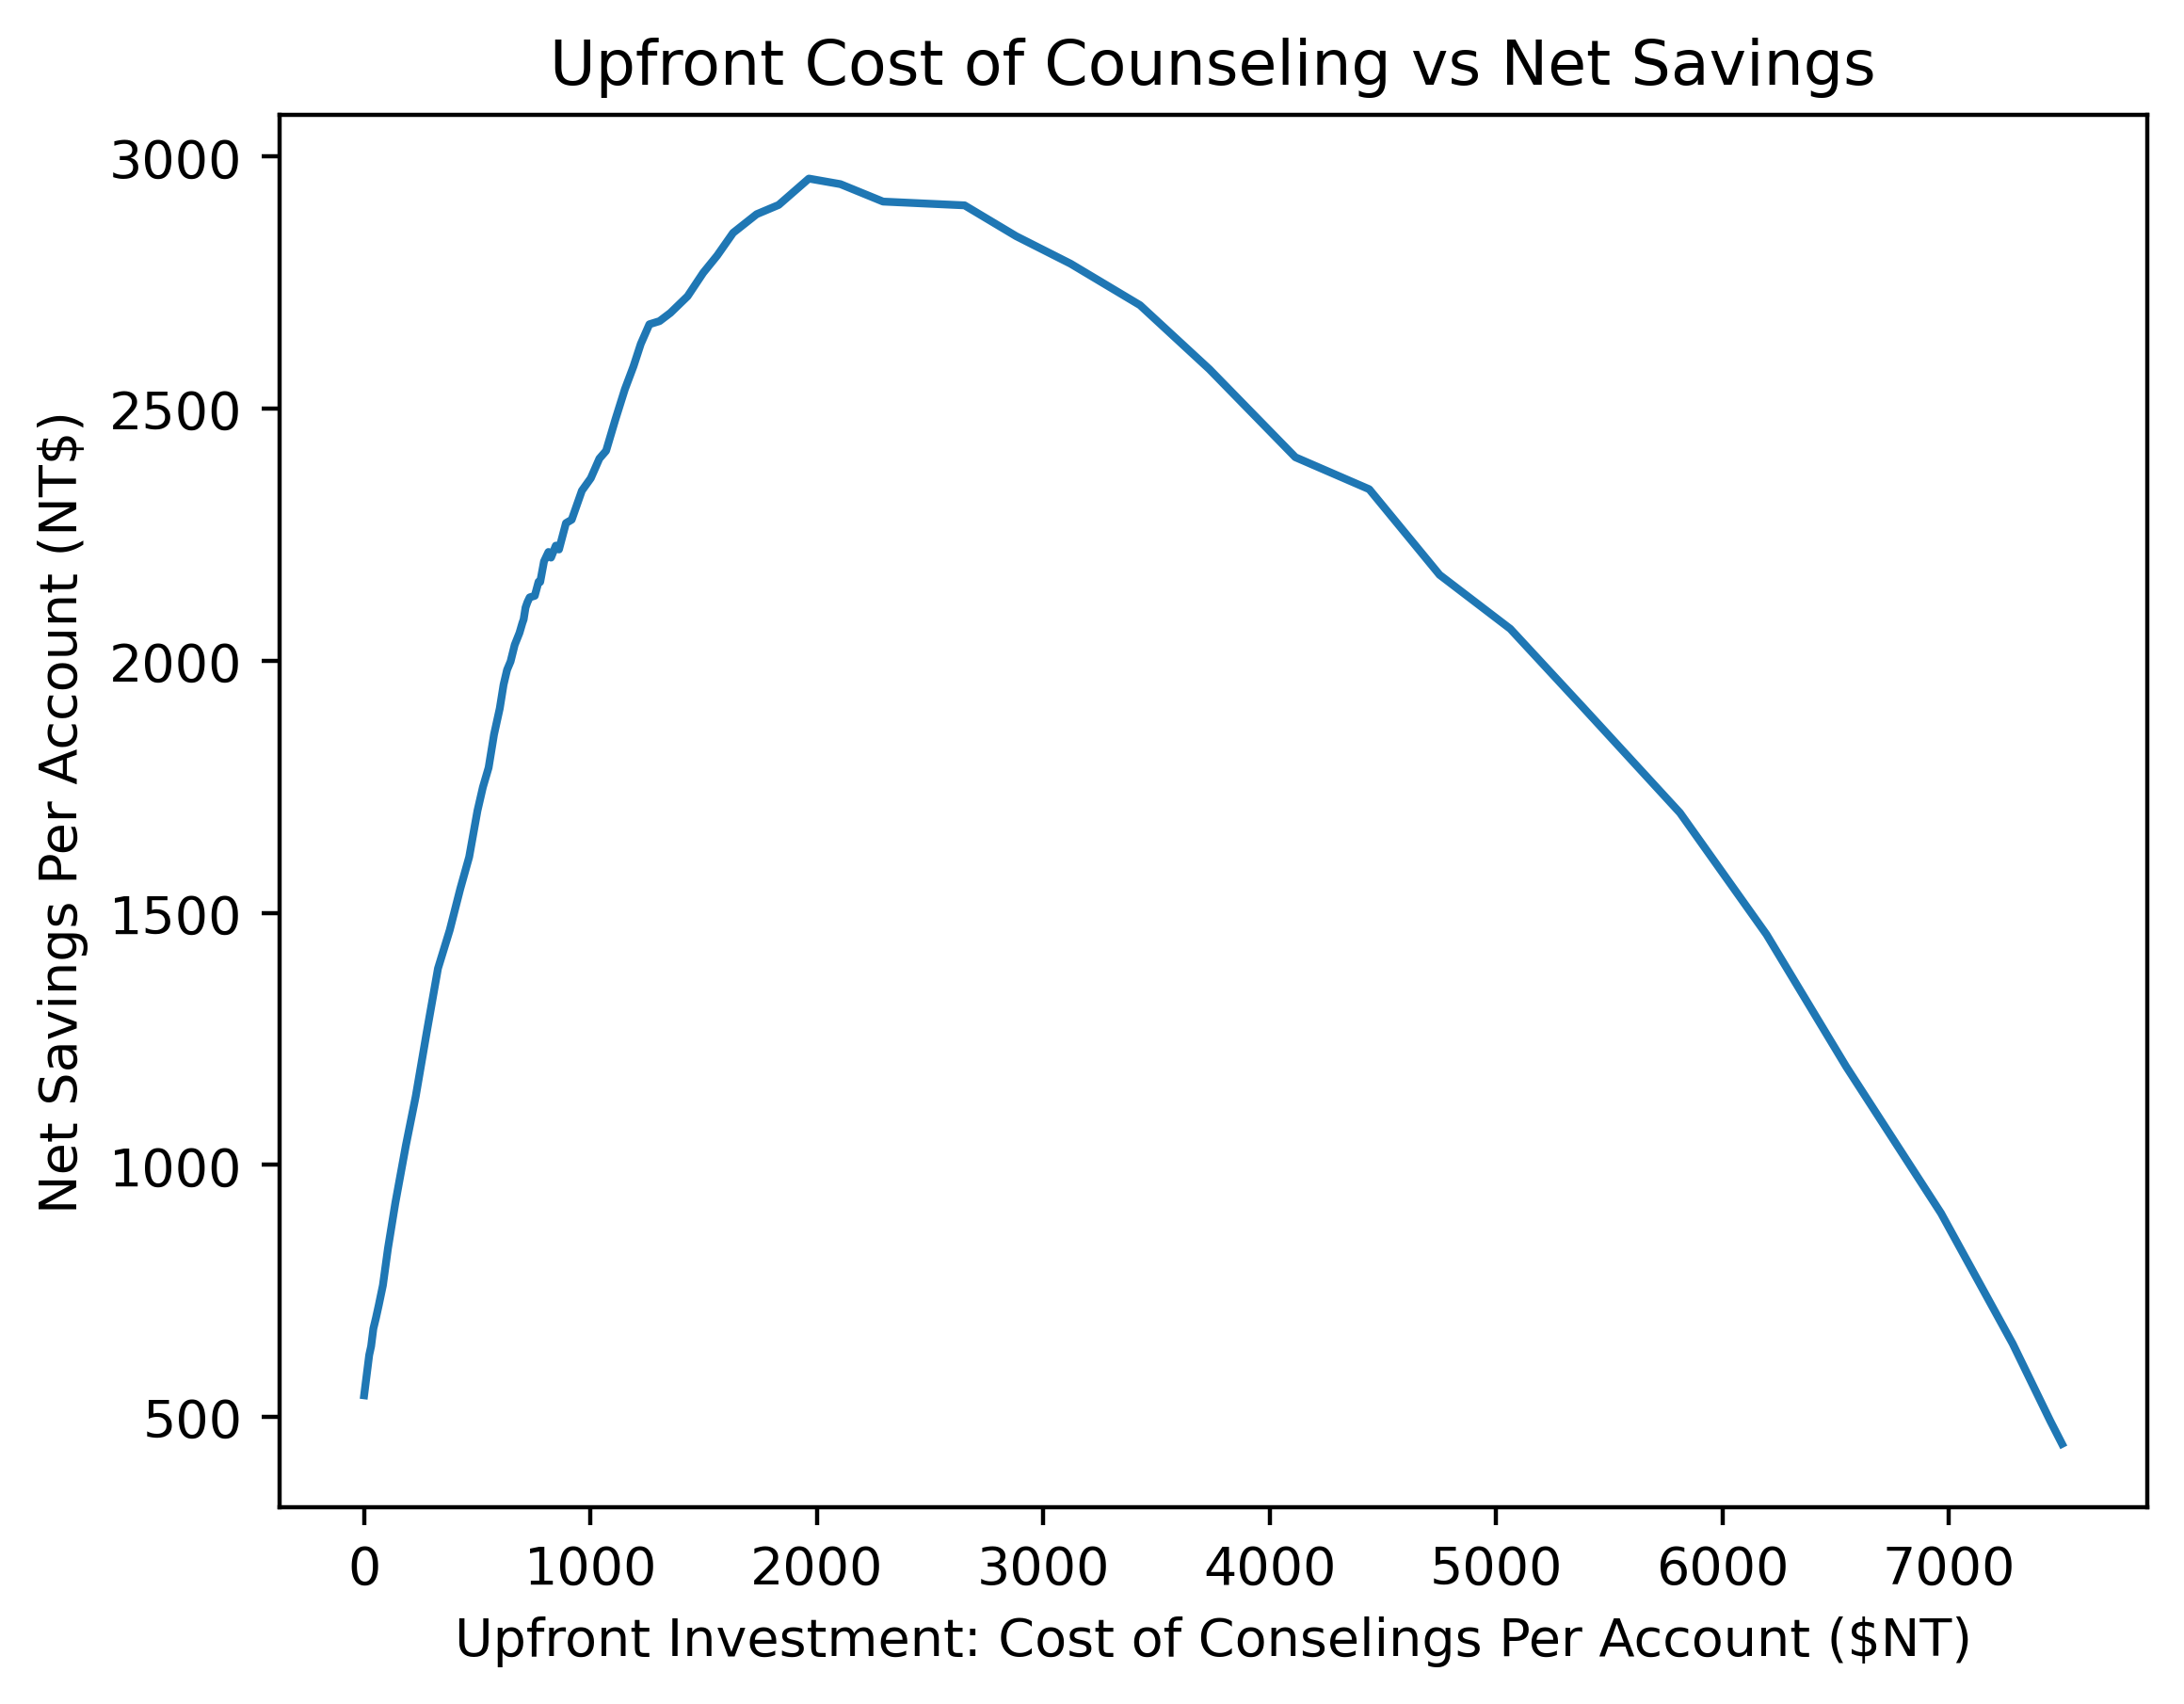

In [100]:
plt.plot(total_cost / len(y_test), net_savings / len(y_test))
plt.xlabel('Upfront Investment: Cost of Conselings Per Account ($NT)')
plt.ylabel('Net Savings Per Account (NT$)')
plt.title('Upfront Cost of Counseling vs Net Savings')

invalid value encountered in divide


Text(0.5, 1.0, 'Recall vs Precision')

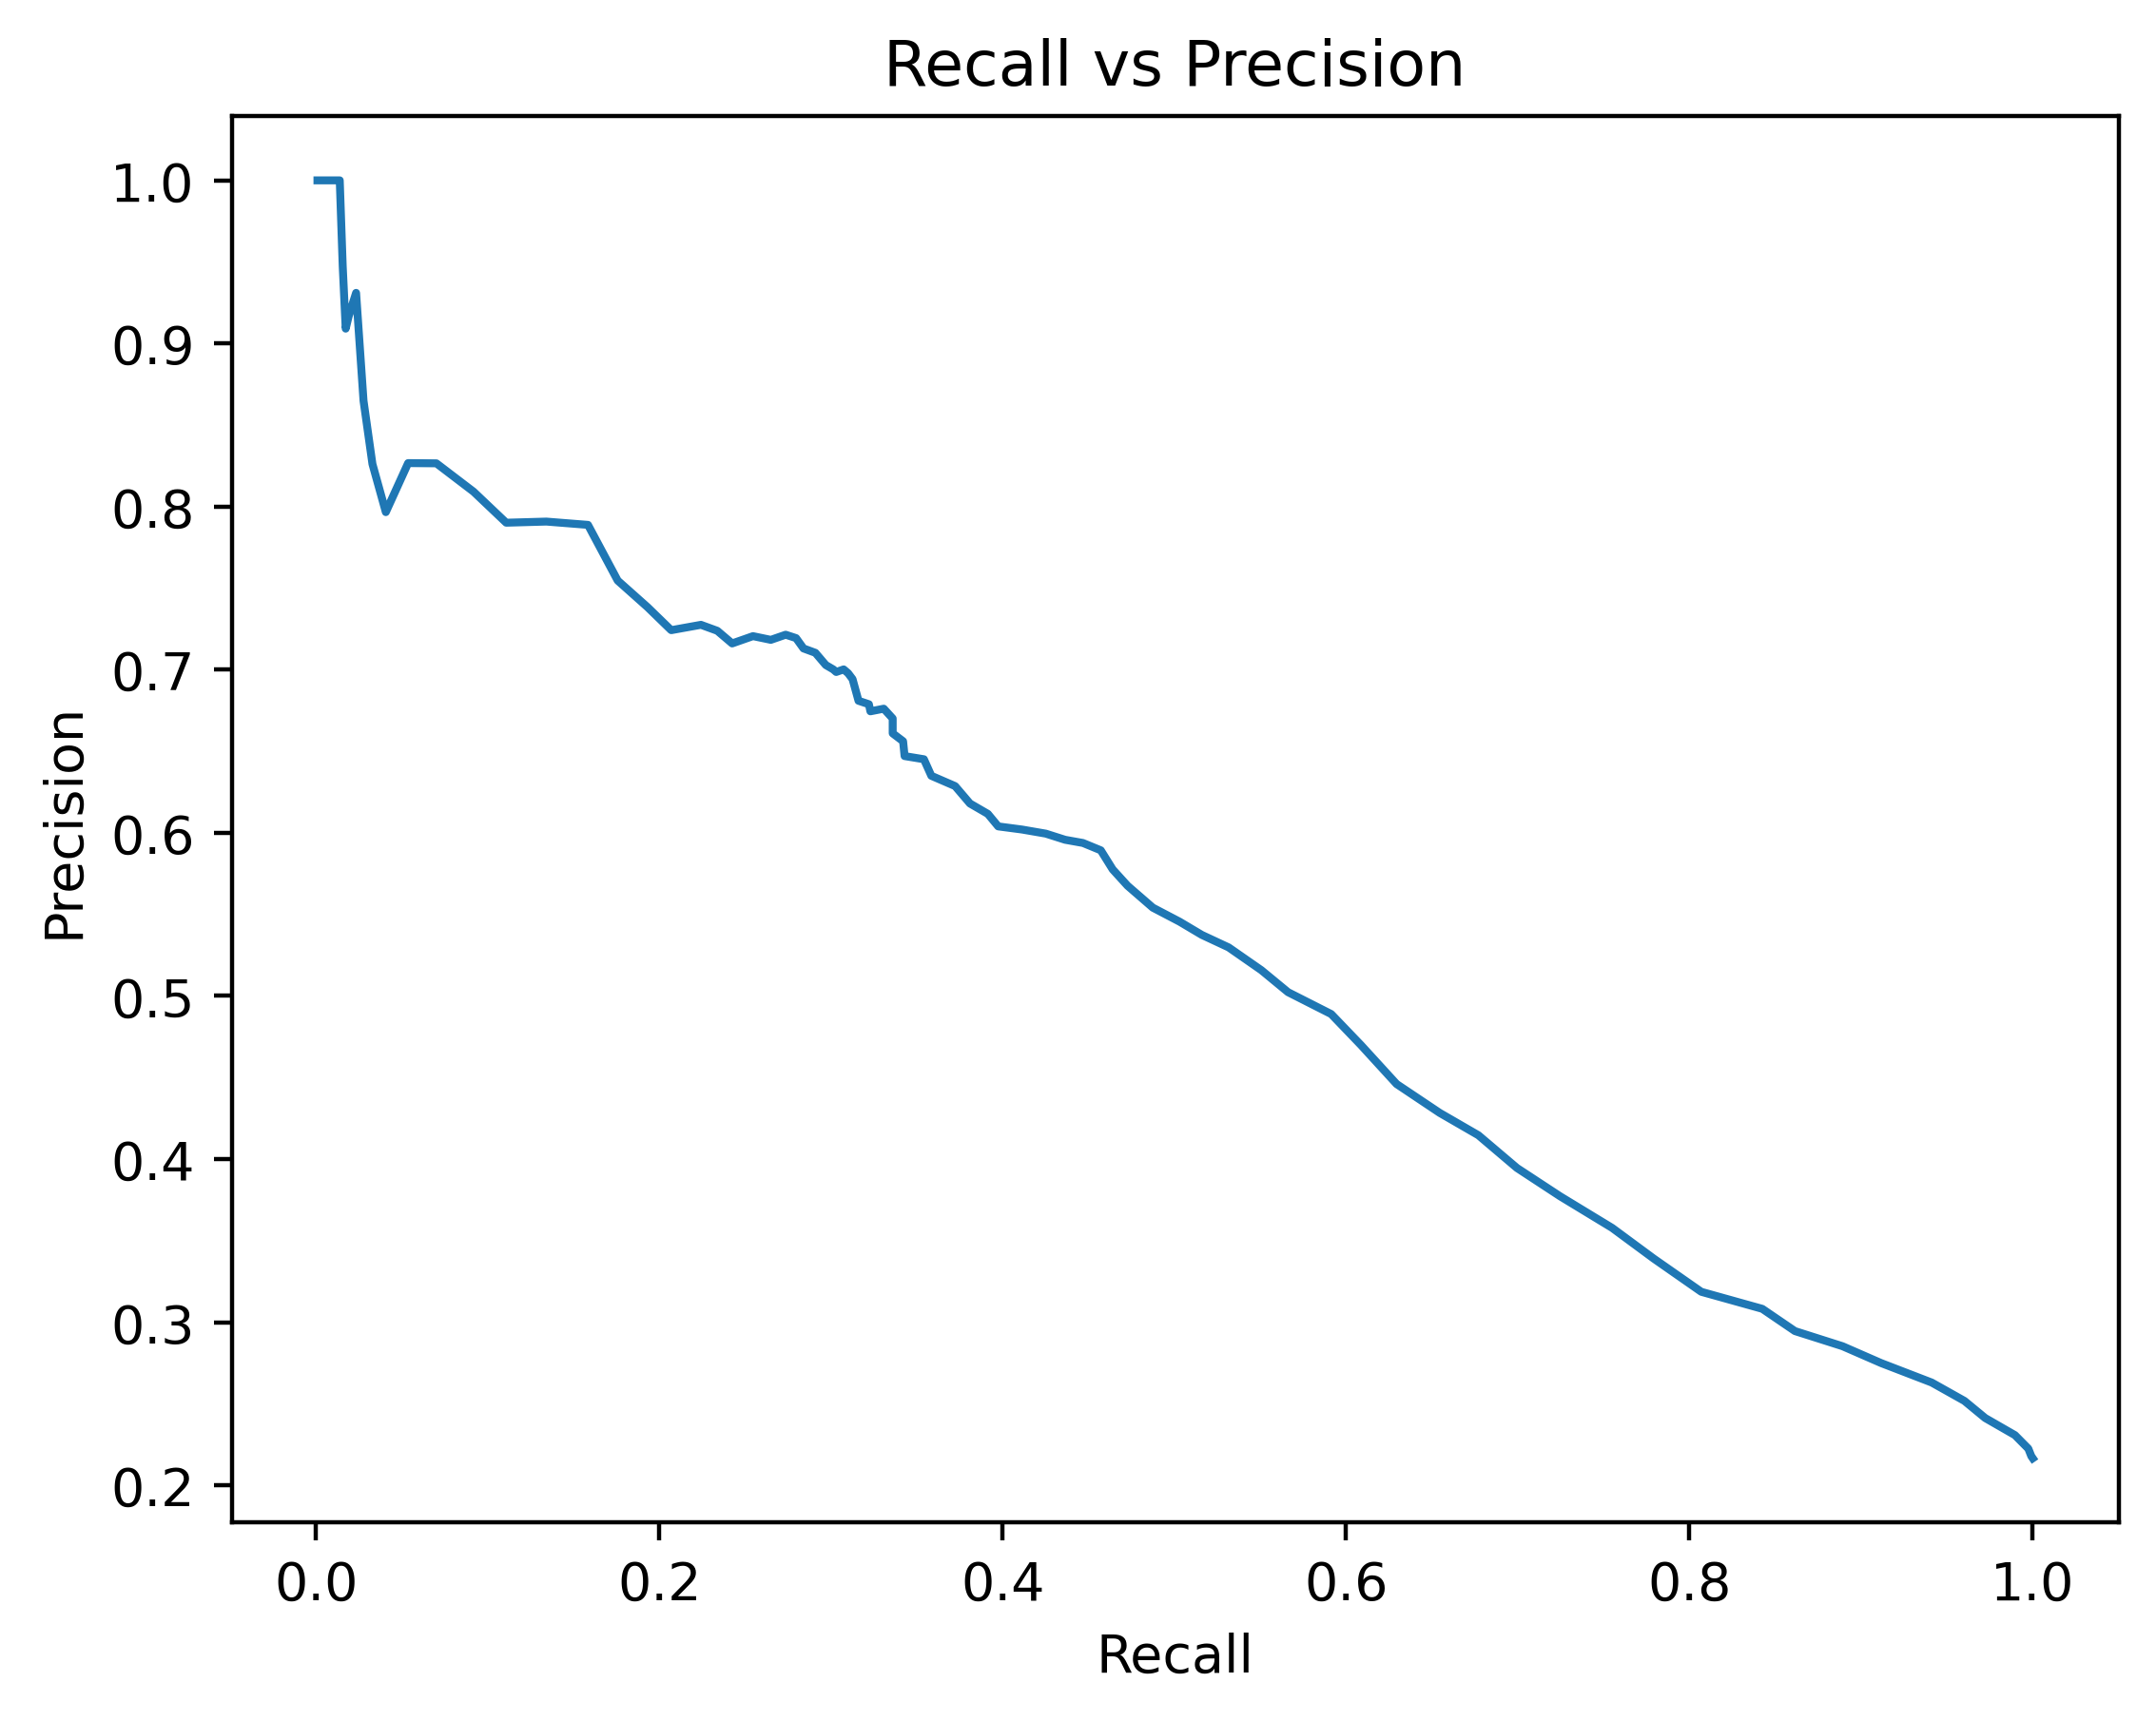

In [101]:
plt.plot(n_true_pos/sum(y_test), n_true_pos/n_pos_pred)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Recall vs Precision')

invalid value encountered in divide


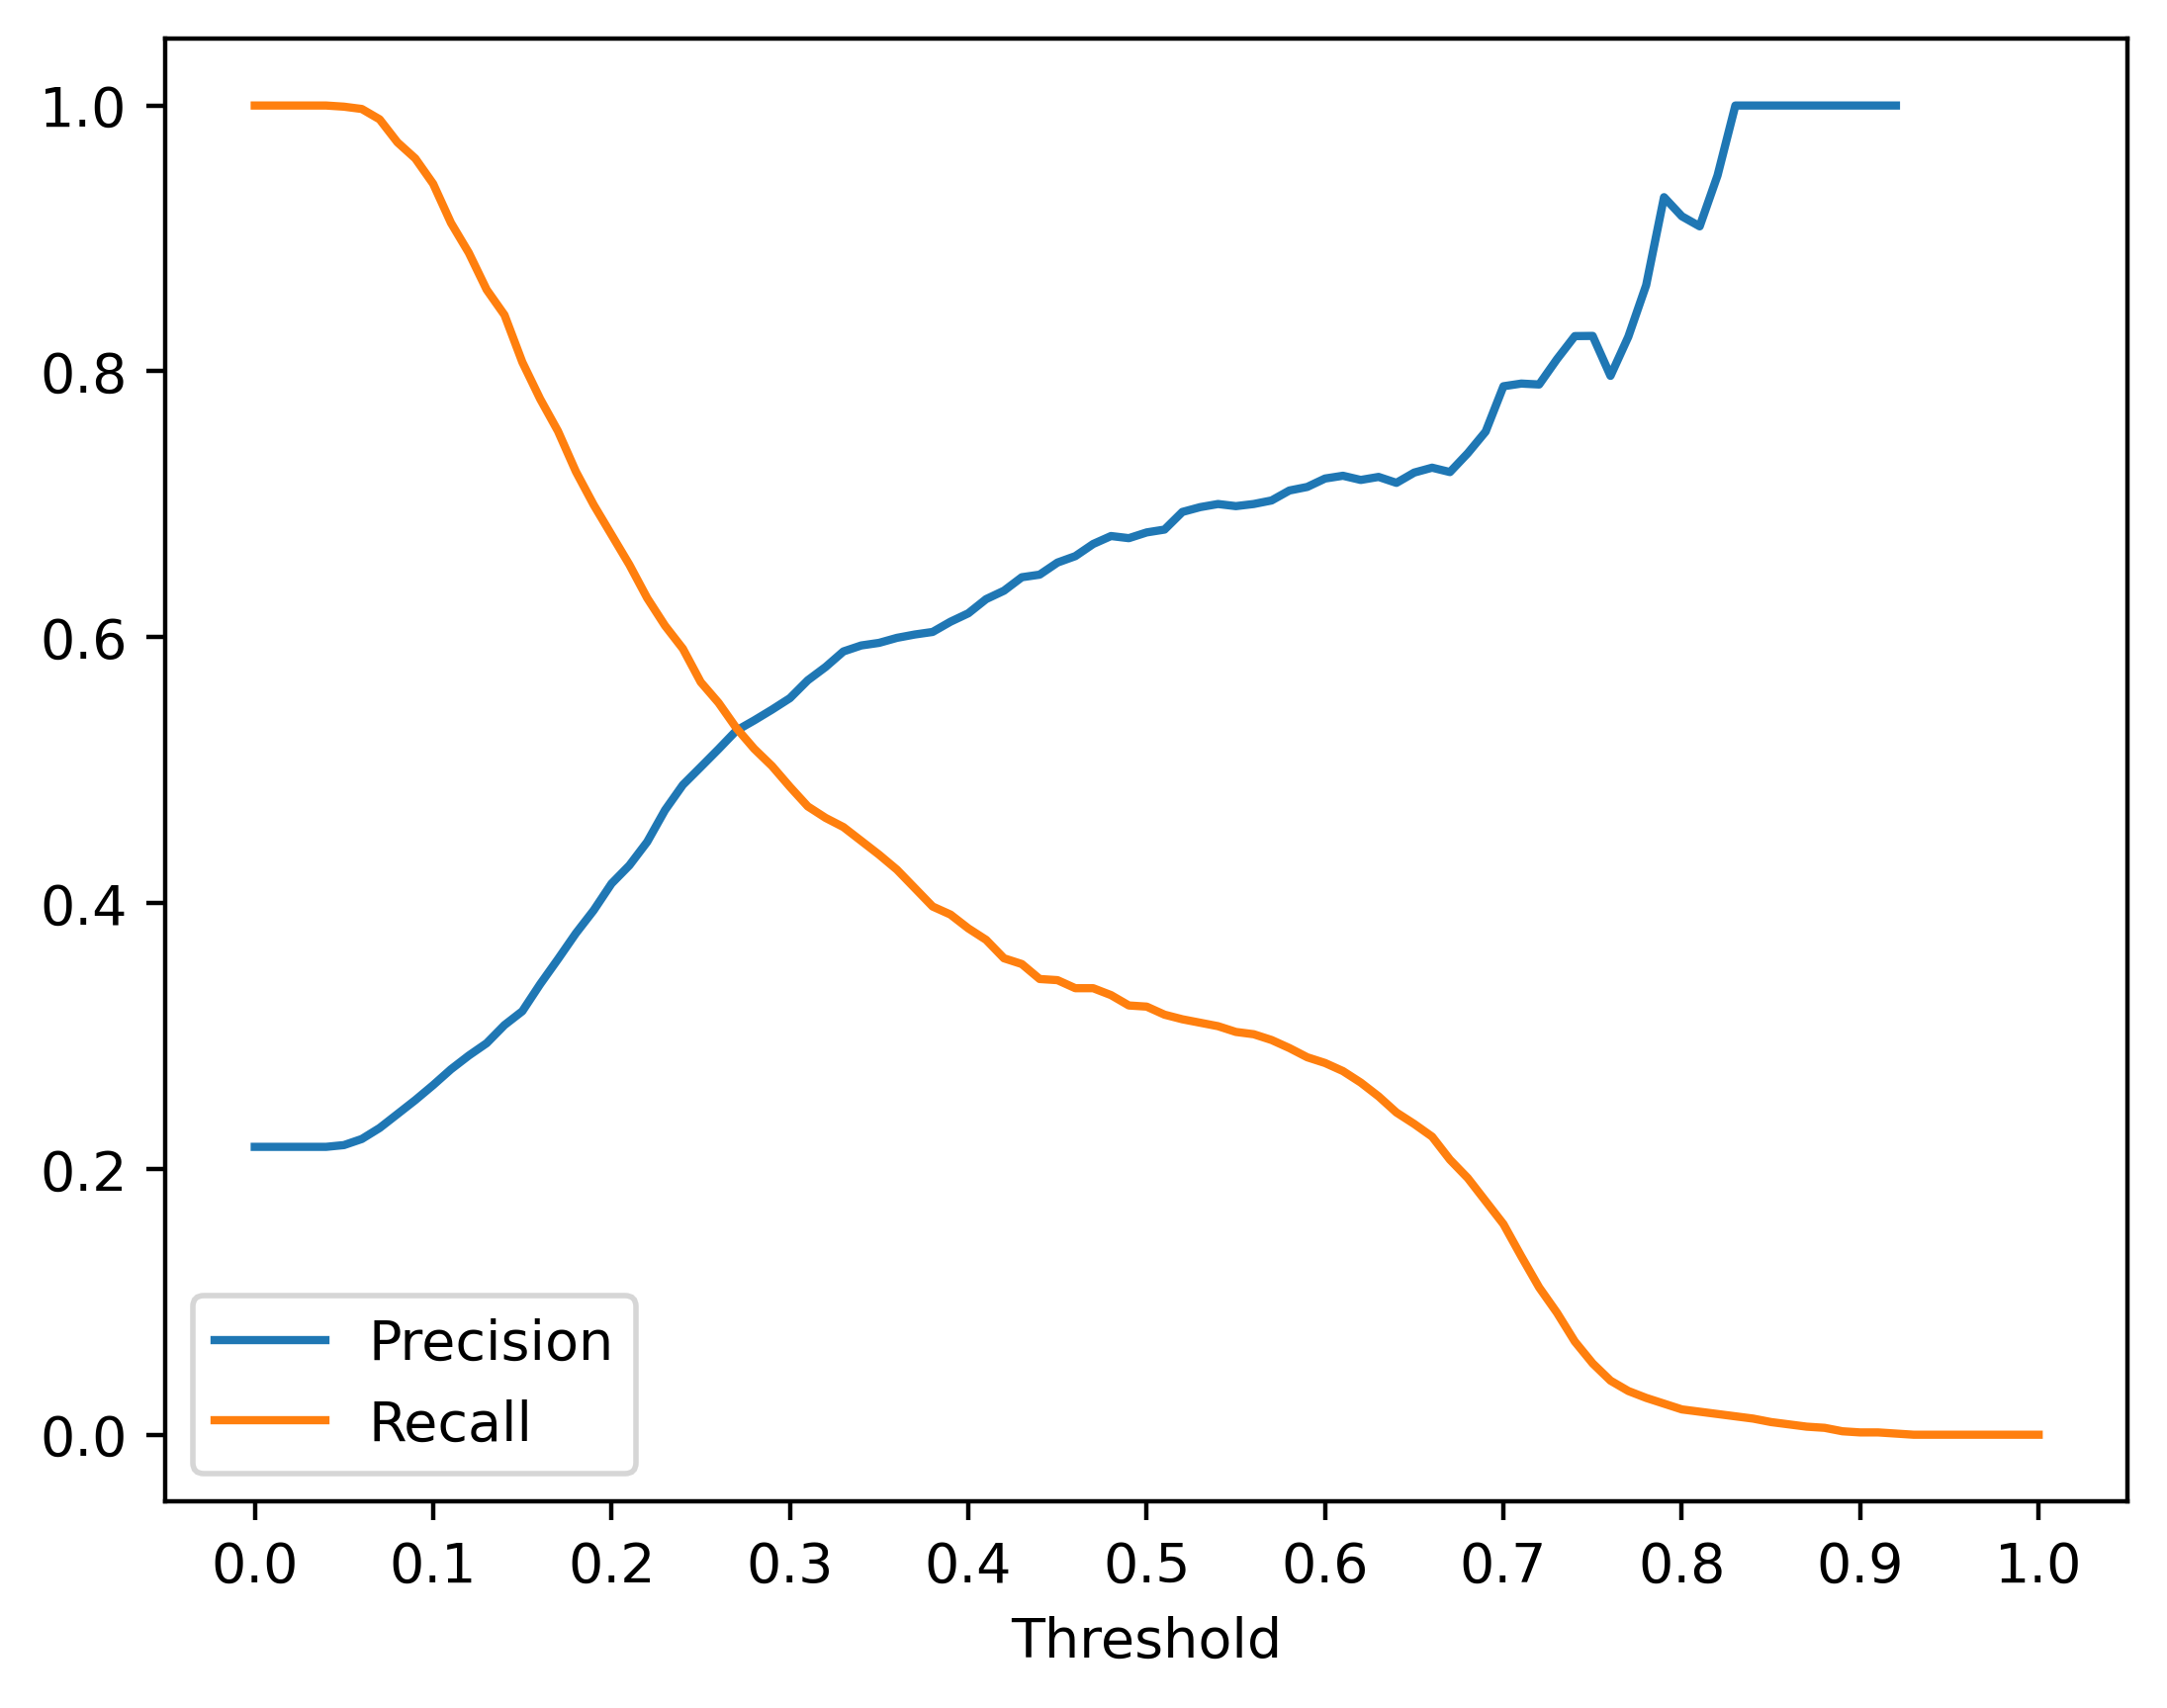

In [103]:
plt.plot(thresholds, n_true_pos/n_pos_pred, label='Precision')
plt.plot(thresholds, n_true_pos/sum(y_test), label='Recall')
plt.xticks(np.linspace(0, 1, 11))
plt.xlabel('Threshold')
plt.legend()